# This notebook is to test if exlcuding bad rating restaurants, how that would impact localness index

In [1]:
import numpy as np
import pandas as pd
# %pip install osmnet
import pandana
# print(pandana.__version__)
import datetime
import traceback
import os 

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")

/home/rongxiang/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# %pip show pandana

In [3]:
import sys
import logging

nblog = open("./logs/localness_pandana_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [4]:
%%time
df_order = pd.read_csv("./data/Dubai_all_delivery_202310_processed.csv", sep=",", header=0)
print(df_order.shape[0])

2919915
CPU times: user 6.42 s, sys: 869 ms, total: 7.29 s
Wall time: 8.21 s


order_time_hour
0     72378 
1     49848 
2     33304 
3     21535 
4     16240 
5     12167 
6     12989 
7     27611 
8     60346 
9     81523 
10    93640 
11    135676
12    205737
13    217752
14    192542
15    169921
16    159401
17    165187
18    213923
19    257187
20    252441
21    203732
22    157684
23    107151
Name: account_id, dtype: int64


<Axes: xlabel='order_time_hour'>

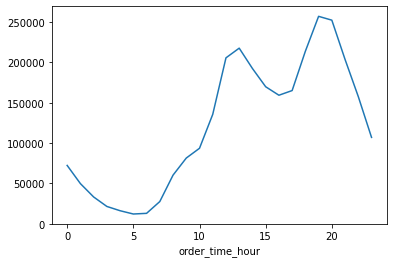

In [72]:
# number of orders by hour
print(df_order.groupby('order_time_hour').count().account_id)
df_order.groupby('order_time_hour').count().account_id.plot(kind='line')

In [81]:
# number of available vendors by hours
df_order.groupby(['order_time_hour']).vendor_id.nunique()

order_time_hour
0     3341
1     2709
2     2103
3     1492
4     1132
5     1058
6     1041
7     1562
8     2440
9     3032
10    4097
11    5689
12    6689
13    6844
14    6814
15    6670
16    6548
17    6532
18    6808
19    6948
20    6927
21    6786
22    6192
23    5073
Name: vendor_id, dtype: int64

In [5]:
available_vendors_list_by_hour = df_order.groupby(['order_time_hour']).vendor_id.unique()

In [60]:
# df_customerlocs = df_order[['account_id','customer_lon','customer_lat']]
# df_customerlocs.drop_duplicates(inplace=True)
# print(df_customerlocs.shape[0])
# df_customerlocs.head()

In [6]:
df_vendor = pd.read_csv('./data/all_vendor_oct_processed.csv',header=0)
df_vendor['vendor_index'] = df_vendor.index
print(df_vendor.shape[0])
df_vendor.head()

8105


,vertical,vendor_id,main_cuisine,vendor_name,vendor_lon,vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


In [86]:
# df_openhours = pd.read_csv('./data/restaurants open status.csv',header=0)
# del(df_openhours['Unnamed: 0'])
# del(df_openhours['vendor_name'])
# print(df_openhours.vendor_id.unique().shape[0])
# df_openhours.head()
# df_vendor = df_vendor.merge(df_openhours, on='vendor_id', how='left')
# print(df_vendor.shape[0])
# print(df_vendor.open_mornings_8_10am.value_counts(dropna=False))
# print(df_vendor.open_afternoons_12_3pm.value_counts(dropna=False))
# print(df_vendor.open_evenings_7_9pm.value_counts(dropna=False))
# print(df_vendor.open_latenights_11_1am.value_counts(dropna=False))
# df_vendor['open_mornings_8_10am'] = df_vendor['open_mornings_8_10am'].fillna('Open')
# df_vendor['open_afternoons_12_3pm'] = df_vendor['open_afternoons_12_3pm'].fillna('Open')
# df_vendor['open_evenings_7_9pm'] = df_vendor['open_evenings_7_9pm'].fillna('Open')
# df_vendor['open_latenights_11_1am'] = df_vendor['open_latenights_11_1am'].fillna('Open')

# Retrieve OSM driving road network of Dubai by bouding box
only need to run download code once, can load the saved network data in the future

In [8]:
# %%time
# ## Wall time: 5min
# from pandana.loaders import osm
# network = osm.pdna_network_from_bbox(24.849396, 54.928797, 25.474479, 55.773907, network_type='drive')

In [7]:
# network.nodes_df.to_csv('./output/nodes.csv')
# network.edges_df.to_csv('./output/edges.csv')
# network.edges_df.head()

In [9]:
%%time
# load existing network data
nodes = pd.read_csv('./output/nodes.csv', index_col=0)
print(nodes.shape[0])
edges = pd.read_csv('./output/edges.csv', index_col=[0,1])
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

110123
CPU times: user 37 s, sys: 584 ms, total: 37.6 s
Wall time: 4.14 s


# Assign nearest network node_ids to each customer location

In [10]:
%%time
all_nodes = network.get_node_ids(df_order.customer_lon, df_order.customer_lat).values
print(all_nodes.shape[0]) #2919915
df_order['node_id'] = all_nodes
print(df_order.node_id.unique().shape[0])  #87601

2919915
41921
CPU times: user 3.13 s, sys: 20.6 ms, total: 3.15 s
Wall time: 3.15 s


In [35]:
# %%time
# customer_nodes = network.get_node_ids(df_customerlocs.customer_lon, df_customerlocs.customer_lat).values
# print(customer_nodes.shape[0])
# df_customerlocs['node_id'] = customer_nodes
# df_customerlocs.node_id.unique().shape[0]

# Identify nearest restaurants
https://github.com/UDST/pandana/blob/dev/examples/Pandana-demo.ipynb

In [11]:
df_vendor = df_vendor.rename(columns={"vendor_id": "n_vendor_id","main_cuisine":"n_main_cuisine",'vendor_name':'n_vendor_name',
                                       'vendor_lon':'n_vendor_lon','vendor_lat':'n_vendor_lat','vertical':'n_vertical'})
print(df_vendor.shape[0])
print(df_vendor.n_main_cuisine.unique().shape[0])
df_vendor.head()

8105
66


,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


In [20]:
# try to merge vendor with ratings 
df_ratings = pd.read_csv('./data/restaurant_ratings.csv')
df_ratings = df_ratings[['vendor_id','rating']]
df_ratings.rename(columns={'rating': 'n_rating', 'vendor_id': 'n_vendor_id'}, inplace=True)
# print(df_ratings.shape[0])
# print(df_ratings.rating.value_counts())
df_vendor = df_vendor.merge(df_ratings, how='left')
df_vendor['n_rating'] = df_vendor['n_rating'].fillna('None')
print(df_vendor.shape[0])

8105


In [22]:
df_vendor.n_rating

n_rating
Very good    4482
None         1787
Amazing      1395
Good         419 
OK           22  
Name: count, dtype: int64

In [49]:
%%time

max_search_resturants = 1 
max_dist = 50000 # 50km 
output_file = './data/Dubai_all_delivery_202310_processed_nearest_new_excludingBadRatings.csv'

# loop hour, for each hour we construct different network with different available restaurants
for hour in range(0,24):
    df_order_byhour = df_order[df_order['order_time_hour']==hour]
    print(datetime.datetime.now(),'Hour:',hour,', total orders in this hour:',df_order_byhour.shape[0])
    df_vendor_byhour = df_vendor[df_vendor['n_vendor_id'].isin(available_vendors_list_by_hour[hour])]
    df_vendor_byhour = df_vendor_byhour[~df_vendor_byhour['n_rating'].isin(['OK', 'Good'])]
    print(' Number of available restaurants:',len(available_vendors_list_by_hour[hour]),df_vendor_byhour.n_vendor_id.unique().shape[0])
    
    # Step 1. Add different types of restaurants into the network. We assume these are the available restaurants to people.
    network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])
    for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
        df_vendor_onetype = df_vendor_byhour[df_vendor_byhour['n_main_cuisine']==cat]
        network.set_pois(category = cat,
                         maxdist = max_dist,
                         maxitems = max_search_resturants, # max number of restaurants to search
                         x_col = df_vendor_onetype.n_vendor_lon, 
                         y_col = df_vendor_onetype.n_vendor_lat)
    
    
    # Step 2. Search the nearest same type of restaurants
    i = 1
    for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
        try:
            print(datetime.datetime.now(), cat, i,'/',df_vendor_byhour.n_main_cuisine.unique().shape[0])
            i+=1
            # return the nearest restaurants offering the same cuisine
            df_nearest_samerest = network.nearest_pois(distance = max_dist,
                                       category = cat,
                                       num_pois = max_search_resturants,
                                       include_poi_ids = True)
            df_nearest_samerest = df_nearest_samerest.reset_index()
            df_nearest_samerest.dropna(inplace=True) # drop nodes without any nearest restaurants within max_dist
            df_nearest_samerest.poi1 = df_nearest_samerest.poi1.astype(int)
            df_nearest_samerest = df_nearest_samerest.rename(columns={"id": "node_id", 1:"nearest_dist1"})# nearest_dist1: this is the distance to the nearest restaurant
            #,"poi1":"vendor_index"

            # left join the identified nearest restaurant with the order data, make sure controling the same cuisine types
            df_order_onetype = df_order_byhour[df_order_byhour['main_cuisine']==cat] 
            df_order_onetype_mergedist = df_order_onetype.merge(df_nearest_samerest, on='node_id')
            df_order_onetype_mergedist = df_order_onetype_mergedist.merge(df_vendor_byhour,left_on='poi1',right_on='vendor_index')

            if not os.path.isfile(output_file):
                df_order_onetype_mergedist.to_csv(output_file,index=False)
            else: # else it exists so append without writing the header
                df_order_onetype_mergedist.to_csv(output_file, mode='a', header=False,index=False)

        except Exception:
            traceback.print_exc()
            print(cat)    

2025-03-10 14:00:10.254982 Hour: 0 , total orders in this hour: 72378
 Number of available restaurants: 3341 3152
2025-03-10 14:00:14.019847 american 1 / 55
2025-03-10 14:00:14.553892 acai 2 / 55
2025-03-10 14:00:15.143462 healthy 3 / 55
2025-03-10 14:00:15.715666 indian 4 / 55
2025-03-10 14:00:16.300871 breakfast 5 / 55
2025-03-10 14:00:17.015897 lebanese 6 / 55
2025-03-10 14:00:17.610306 asian 7 / 55
2025-03-10 14:00:18.122562 fast food 8 / 55
2025-03-10 14:00:19.222178 bbq 9 / 55
2025-03-10 14:00:19.808162 yemeni 10 / 55
2025-03-10 14:00:20.593554 arabic 11 / 55
2025-03-10 14:00:21.256160 chinese 12 / 55
2025-03-10 14:00:21.965775 seafood 13 / 55
2025-03-10 14:00:22.745949 mexican 14 / 55
2025-03-10 14:00:23.247479 dessert 15 / 55
2025-03-10 14:00:23.920297 salad 16 / 55
2025-03-10 14:00:24.633276 international 17 / 55
2025-03-10 14:00:25.159496 middle eastern 18 / 55
2025-03-10 14:00:25.869930 italian 19 / 55
2025-03-10 14:00:26.544300 african 20 / 55
2025-03-10 14:00:27.219668 pak

# Compute shortest path (network distance) between customer and restaurants actually ordering from

In [50]:
%%time
df_localness = pd.read_csv('./data/Dubai_all_delivery_202310_processed_nearest_new_excludingBadRatings.csv', sep=",", header=0, on_bad_lines="skip")
print(df_localness.shape[0])

2916498
CPU times: user 7.94 s, sys: 2.33 s, total: 10.3 s
Wall time: 10.3 s


In [51]:
df_localness.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,node_id,nearest_dist1,poi1,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index,n_rating
0,1237695,1304769890,2023-10-10,2023-10-10 00:54:08,701885,"Subz, AlBarsha 3",american,food,7.50000,1.92000,64.00000,True,30.00000,249052903.00000,55.14407,25.06988,55.19383,25.08783,0,21,50,2669233716,687.06598,1778,food,660366,american,"Cheat Day - Burgers & Salads, Jumeirah Lakes Towers",55.14022,25.06550,1778,Very good
1,1027548,1304769334,2023-10-10,2023-10-10 00:53:16,701885,"Subz, AlBarsha 3",american,food,7.50000,1.92000,64.00000,True,30.00000,249052903.00000,55.14435,25.06983,55.19383,25.08783,0,16,46,2669233716,687.06598,1778,food,660366,american,"Cheat Day - Burgers & Salads, Jumeirah Lakes Towers",55.14022,25.06550,1778,Very good


In [52]:
# nearest_dist1:
df_localness['nearest_dist1'] = df_localness['nearest_dist1']/1000  # convert to km

In [53]:
%%time
# first, identify the nearest node to each lon lat coordinate
customer_nodes = network.get_node_ids(df_localness.customer_lon, df_localness.customer_lat).values
vendor_nodes = network.get_node_ids(df_localness.vendor_lon, df_localness.vendor_lat).values

# second, compute the shortest network distance for each pair of nodes
distances_order = network.shortest_path_lengths(vendor_nodes, customer_nodes)

print(len(distances_order))
# pandana_distance_realdist: this is the real network distance between customer and the vendor
df_localness['pandana_distance_realdist'] = [x / 1000 for x in distances_order] # convert to km

2916498
CPU times: user 1min 53s, sys: 87.8 ms, total: 1min 53s
Wall time: 10.4 s


In [36]:
# %%time
# n_vendor_nodes = G.get_node_ids(df_order.n_vendor_lon, df_order.n_vendor_lat).values
# distances_to_nearest_restaurants = G.shortest_path_lengths(n_vendor_nodes, customer_nodes)
# df_localness['pandana_distance_nearest_dist'] = [x / 1000 for x in distances_to_nearest_restaurants] 

# Localness index exploration

In [64]:
df_localness['pandana_localness'] = df_localness['nearest_dist1']/df_localness['pandana_distance_realdist']

In [10]:
# %%time
# df_localness = pd.read_csv('./data/food_localness_oct.csv',header=0)

CPU times: user 18.2 s, sys: 896 ms, total: 19.1 s
Wall time: 1min 13s


In [40]:
# before excluding abnormal values
# print(df_localness.shape[0])
# df_localness.pandana_distance_realdist.describe()

In [39]:
# df_localness.delivery_duration.describe()
# df_localness.total_duration.describe()

In [65]:
# exclude some extreme or abnormal orders based on distance and speed
df_localness = df_localness[df_localness['pandana_distance_realdist']<50] # order distance must be less than 50km
df_localness['speed'] = df_localness['pandana_distance_realdist']/(df_localness['delivery_duration']/60) # order travel speed, km/h
df_localness = df_localness[df_localness['speed']<60] #must be < 60km/h
df_localness = df_localness[df_localness['pandana_localness']<=1.00001]

In [66]:
# After exclude abnormal values: 2.8 million orders
print(df_localness.shape[0])
df_localness.pandana_distance_realdist.describe()

2677793


count   2677793.00000
mean    5.82294      
std     4.02765      
min     0.00446      
25%     2.70292      
50%     4.94292      
75%     8.16305      
max     46.27318     
Name: pandana_distance_realdist, dtype: float64

In [67]:
# around 4.8% of the orders are from the nearest restaurants: 
print(df_localness[df_localness['pandana_localness']>=1].shape[0])
print(df_localness[df_localness['pandana_localness']>=1].shape[0]/df_localness.shape[0])

2229
0.0008324019070928933


In [68]:
df_localness.groupby('main_cuisine').pandana_localness.mean().sort_values(ascending=False)

main_cuisine
peruvian          1.00000
specialty store   1.00000
latin american    1.00000
iraqi             1.00000
kuwaiti           1.00000
spanish           1.00000
french            0.99884
mongolian         0.98902
singaporean       0.97834
tunisian          0.96135
argentinian       0.92931
sliders           0.90261
saudi             0.88422
portuguese        0.87866
brazilian         0.86957
british           0.84006
syrian            0.83512
georgian          0.80606
gluten free       0.80321
indonesian        0.80067
vietnamese        0.78166
nepalese          0.77578
european          0.75269
mediterranean     0.74500
middle eastern    0.73989
jordanian         0.72724
soup              0.70734
greek             0.70535
korean            0.68906
bowls             0.68204
moroccan          0.67967
keto              0.64563
russian           0.63499
afghani           0.62986
vegetarian        0.62109
uzbek             0.61413
palestinian       0.61262
chicken           0.59338

<Axes: >

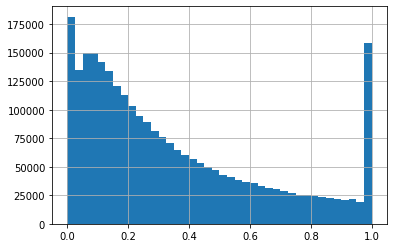

In [69]:
df_localness['pandana_localness'].hist(bins=40,ec='None')

In [80]:
df_localness.to_csv('./data/food_localness_oct_OnlyGoodRatings.csv',sep=',',index=False)

In [97]:
dfneed1 = df_localness[['account_id', 'order_id', 'pandana_localness']]
dfneed1.rename(columns={'pandana_localness': 'pandana_localness_onlygood'},inplace=True)

In [ ]:
dfneed2 = pd.read_csv('./data/food_localness_final_oct_new.csv')

In [94]:
dfneed2 = dfneed2[['account_id', 'order_id', 'pandana_localness']]

In [98]:
df_compare = pd.merge(dfneed1, dfneed2, how='left')

In [107]:
print(df_compare.shape[0])
df_compare.dropna(inplace=True)
print(df_compare.shape[0])

2635483
2635483


In [108]:
# %%time
# from scipy.stats import mannwhitneyu

# stat, p = mannwhitneyu(df_compare.pandana_localness, df_compare.pandana_localness_onlygood, alternative='two-sided')
# print(stat, p)

3455178009733.5 3.758704217090414e-24
CPU times: user 4.98 s, sys: 12 ms, total: 4.99 s
Wall time: 5 s


In [109]:
df_compare['diff_localness'] = df_compare['pandana_localness'] - df_compare['pandana_localness_onlygood']

In [111]:
df_compare['diff_localness'].describe()

count   2635483.00000
mean    -0.00342     
std     0.03343      
min     -0.99968     
25%     0.00007      
50%     0.00012      
75%     0.00021      
max     0.18315      
Name: diff_localness, dtype: float64